# Scripts for editors

- lookup a title on the **arxiv** and return an abstract
- get the **MSC** classifications
- get references from a PDF and do some stats



In [1]:
import requests
import re

#  Lookup arxiv


Do an **arxiv** search for the title and attempt to return the abstract

ss = 'https://arxiv.org/search/?query=The+Grunwald+problem+and+homogeneous+spaces+with+non-solvable+stabilisers&searchtype=title&abstracts=show&order=-announced_date_first&size=50'

In [86]:
pabs = re.compile('<span class="abstract-full.*?>(.*?)<a', re.DOTALL)

def get_arxiv(title):
    
    s_title = '+'.join(title.split() )
    user_agent = {'User-Agent': "Mozilla/5.0 (X11; CrOS x86_64 13099.62.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.83 Safari/537.36"}
    
    params = {"query": s_title,
              "searchtype" : "title",
              "abstract" : "show",
              "order" : "-announced_date_first",
              "size" : "50"}
    
    r = requests.get(url= "https://arxiv.org/search",
                 headers = user_agent,
                 params = params
                )
    if r.status_code == 200 :
        return r
    else:
        return None

## Usage 

In [87]:
tt = "Right-angled Artin subgroups and free products in one-relator groups"
tt = 'SOME GEOMETRIC APPLICATIONS OF THE DISCRETE HEAT FLOW'

xx = get_arxiv(tt)

print(f'who would be a good referee for this article:\n\nTitle: {tt}\n\n {pabs.search(xx.text).group(1).strip()}')

who would be a good referee for this article:

Title: SOME GEOMETRIC APPLICATIONS OF THE DISCRETE HEAT FLOW

 We present two geometric applications of heat flow methods on the discrete hypercube $\{-1,1\}^n$. First, we prove that if $X$ is a finite-dimensional normed space, then the bi-Lipschitz distortion required to embed $\{-1,1\}^n$ equipped with the Hamming metric into $X$ satisfies $$\mathsf{c}_X\big(\{-1,1\}^n\big) \gtrsim \sup_{p\in[1,2]} \frac{n}{\mathsf{T}_p(X) \min\{n,\mathrm{dim}(X)\}^{1/p}},$$ where $\mathsf{T}_p(X)$ is the Rademacher type $p$ constant of $X$. This estimate yields a mutual refinement of distortion lower bounds which follow from works of Oleszkiewicz (1996) and Ivanisvili, van Handel and Volberg (2020) for low-dimensional spaces $X$. The proof relies on an extension of an important inequality of Pisier (1986) on the biased hypercube combined with an application of the Borsuk-Ulam theorem from algebraic topology. Secondly, we introduce a new metric invariant

---


# MSC classification

easily scraped as follows

actually you can pull them as a CSV from https://msc2020.org/ but it's not utf-8 encoded (see below)

In [2]:
import re
import requests
url = 'https://cran.r-project.org/web/classifications/MSC.html'
r = requests.get(url=url)
with open('./MSC Classification Codes.mhtml','w') as fp:
    fp.write(r.text)

In [3]:
with open('./MSC Classification Codes.mhtml','r') as fp:
    data = fp.read()

01A72: Schools of mathematics</li>

In [62]:
kpp = re.compile(r'(\d{2}[A-Z]\d{2}):\s+(.*?)<')
codes = dict(kpp.findall(data))

In [63]:
codes['11G05']

'Elliptic curves over global fields'

In [32]:
with open('./MSC_2020.csv','rb') as fp:
    ss = fp.read().decode(errors='replace')

mscp = re.compile('"(\d{2}.*?\d{2})"\s+"(.*?)"')
MSC = dict(mscp.findall(ss))


In [33]:
MSC['11G05']

'Elliptic curves over global fields'

https://arxiv.org/search/?query=46B85&searchtype=msc_class&source=header

In [44]:
def get_arxiv_msc(code):
    
    user_agent = {'User-Agent': "Mozilla/5.0 (X11; CrOS x86_64 13099.62.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.83 Safari/537.36"}
    
    params = {"query": code,
              "searchtype" : "msc_class",
              "source" : "header"
             }
    
    r = requests.get(url= "https://arxiv.org/search",
                 headers = user_agent,
                 params = params
                )
    if r.status_code == 200 :
        return r
    else:
        return None

In [45]:
r  = get_arxiv_msc("11G05")

<p class="title is-5 mathjax">
      
        Metric Dimension and Resolvability of Jaccard Spaces
      
    </p>
    <p class="authors">
      <span class="has-text-black-bis has-text-weight-semibold">Authors:</span>
      
      <a href="/search/?searchtype=author&amp;query=Lladser%2C+M+E">Manuel E. Lladser</a>, 
      
      <a href="/search/?searchtype=author&amp;query=Paradise%2C+A+J">Alexander J. Paradise</a>
      
    </p>

In [62]:
ppart = re.compile(r'<p class="title.*?>(.*?)</p>.*?Authors:</span>(.*?)</p>',re.DOTALL)
titles, auts  = list(zip(*ppart.findall(r.text)))

In [68]:
titles = [_.strip() for _ in titles]
paut = re.compile(r'>(.*?)</')
[paut.findall(_) for _ in auts][:5]


[['Pratiksha Shingavekar'],
 ['Katharina Müller', 'Anwesh Ray'],
 ['Yifeng Liu', 'Yichao Tian', 'Liang Xiao'],
 ['Naoto Dainobu'],
 ['Ben Kane', 'Sudhir Pujahari', 'Zichen Yang']]

In [67]:
titles[5]

'Sesquilinear pairings on elliptic curves'

---

# Mining a PDF for references 

- pull the MSC codes
- scrape the references using re/regex
- do some stats on dates and check for author names


[{'Producer': b'pdfTeX-1.40.22', 'Author': b'', 'Title': b'', 'Subject': b'', 'Creator': b'LaTeX with hyperref', 'Keywords': b'', 'CreationDate': b"D:20231003101034+02'00'", 'ModDate': b"D:20231003101034+02'00'", 'Trapped': /'False', 'PTEX.Fullbanner': b'This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2021) kpathsea version 6.3.3'}]


In [18]:
import os
from io import StringIO
import re
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage


def pdf_to_text(path):
    '''Extract text from pdf documents
    '''

    manager = PDFResourceManager()
    retstr = StringIO()
    layout = LAParams(all_texts=False, detect_vertical=True)
    device = TextConverter(manager, retstr, laparams=layout)
    interpreter = PDFPageInterpreter(manager, device)
    with open(path, 'rb') as filepath:
        for page in PDFPage.get_pages(filepath, check_extractable=True):
            interpreter.process_page(page)
    text = retstr.getvalue()
    device.close()
    retstr.close()
    return text

In [36]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument

fp = open(fn, 'rb')
parser = PDFParser(fp)
doc = PDFDocument(parser)

print(doc.info)  # The "Info" metadata

[{'Author': b'', 'Title': b'', 'Subject': b'', 'Creator': b'LaTeX with hyperref package', 'Producer': b'pdfTeX-1.40.18', 'Keywords': b'', 'CreationDate': b"D:20230522164711+02'00'", 'ModDate': b"D:20230522164711+02'00'", 'Trapped': /'False', 'PTEX.Fullbanner': b'This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) kpathsea version 6.2.3'}]


In [35]:
import os
base = os.environ['HOME']  + '/'
pdfs = [_ for _ in os.listdir(base) if _[-3:] == 'pdf']

fn = base + pdfs[-1]

In [27]:
art_txt = pdf_to_text(fn)
with open(fn.split('/')[-1][:-3] + '.tex','w') as fp:
    fp.write(art_txt)

In [29]:
#a  reference in the biblio has the form
#[number](space)(Initial)(text up to next occurence of [)
rp = re.compile(r'(\[\d+\]\s+[A-Z][^\[]*)',re.DOTALL)
dp = re.compile(r'\d{4}')
pmrc = re.compile(r'\d{2}[A-Z]+\d{2}')

In [37]:
mscs = pmrc.findall(art_txt)
# this should never fail now we have MSC 2020 in csv
[_ + ' ' +  MSC[_] for _ in mscs ]

['11N37 Asymptotic results on arithmetic functions',
 '11R20 Other abelian and metabelian extensions',
 '11R34 Galois cohomology']

In [38]:
#tt = re.sub(r'\[','\[\[',tt)
raw_refs = rp.findall(art_txt)
unhyphenated = [re.sub('\-[\n]','',_) for _ in  raw_refs[:] ]
clean_refs = [re.sub('[\n]+',' ',_) for _ in  unhyphenated ]

ref_texts = '\n\n'.join(clean_refs)
#should clean up the names so just have ascii characters
ref_texts = re.sub('[¨]','',ref_texts)

nums = [dp.findall(_) for _ in clean_refs]
dates = [ [x for x in _ if 1900 < int(x) < 2024] for _ in nums]
dates = [ _ for _ in dates if _ ]
dates = [ max(_) for _ in dates ]

In [109]:
name = 'KOYMANS'

px = re.compile(f'\[\d+\].*?{name}.*')
px.findall(ref_texts.upper())[:-1]

['[22] P. KOYMANS AND C. PAGANO, ON THE DISTRIBUTION OF CL(K)']

---

# Do stats on the dates 

In [40]:
import matplotlib.pyplot as plt

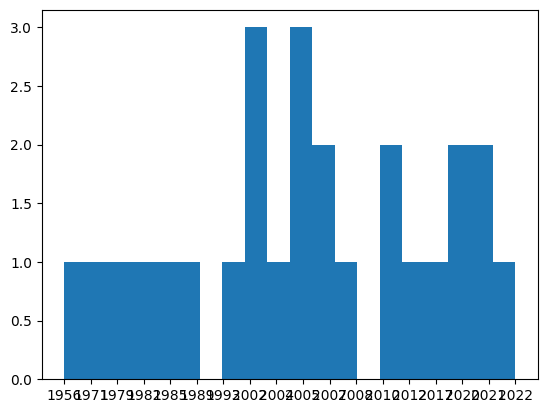

In [41]:
dates.sort()
plt.hist(dates, bins = 20);